In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import signal
import cv2 as cv

# Filtro circular promediador

Info sobre coeficientes de filtros: http://matlab.izmiran.ru/help/toolbox/images/fspecial.html#250030

Codigo fuente matlab: https://searchcode.com/codesearch/view/9511844/

In [ ]:
"""
Genera Kernel de filtro circular promediador. La matemática del mismo funciona de la siguiente manera:
El kernel es rectangular y recibo un radio r de un círculo, por ende se crea un kernel de lado 2*r + 1. 
Se subdivide dicho kernel en una grilla con (2*r + 1)^2 cuadrados y se traza un circulo iamginario en el mismo. 
Hay casillas que están completamente cubiertas por el circulo circunscrito, mientras que otras están parcilmente cubiertas y hay un grupo que no están cubiertas.
Se calcula la proporción de cada casilla que está cubierta por el circulo imaginario y así se determinan las intensidades relativas de cada casilla.
Finalmente se normaliza el kernel. 
"""
def generateDisk(r):
    crad = np.ceil(r - 0.5)
    arr = np.arange(-crad, crad + 1)
    x, y = np.meshgrid(arr, arr)

    maxxy = np.maximum(np.abs(x), np.abs(y))
    minxy = np.minimum(np.abs(x), np.abs(y))

    m1Term1 = (r ** 2 < np.square(maxxy + 0.5) + np.square(minxy - 0.5)) * 1
    m1Term2 = (r ** 2 >= np.square(maxxy + 0.5) + np.square(minxy - 0.5)) * 1

    m2Term1 = (r ** 2 > np.square(maxxy - 0.5) + np.square(minxy + 0.5)) * 1
    m2Term2 = (r ** 2 <= np.square(maxxy - 0.5) + np.square(minxy + 0.5)) * 1

    rArr = np.full(maxxy.shape, r**2)

    m1 = np.multiply(m1Term1, minxy - 0.5) + np.multiply(m1Term2,
                                                         np.sqrt(rArr - np.square(maxxy + 0.5, dtype=np.complex64)))
    m2 = np.multiply(m2Term1, minxy + 0.5) + np.multiply(m2Term2,
                                                         np.sqrt(rArr - np.square(maxxy - 0.5), dtype=np.complex64))

    m1 = m1.astype('float64');
    m2 = m2.astype('float64');

    term1 = (r ** 2 * (0.5 * (np.arcsin(m2 / r, dtype="complex64") - np.arcsin(m1 / r, dtype="complex64")) + 0.25 * (
                np.sin(2 * np.arcsin(m2 / r, dtype="complex64")) - np.sin(2 * np.arcsin(m1 / r, dtype="complex64"), dtype="complex64")))) - np.multiply(maxxy - 0.5, m2 - m1) + (
                        m1 - minxy + 0.5)

    t1 = (r ** 2 < np.square(maxxy + 0.5) + np.square(minxy + 0.5)) * 1
    t2 = (r ** 2 > np.square(maxxy - 0.5) + np.square(minxy - 0.5)) * 1

    t31 = minxy == 0
    t32 = maxxy - 0.5 < r
    t33 = maxxy + 0.5 >= r

    temp = np.logical_and(t31, t32)
    t3 = np.logical_and(temp, t33) * 1

    term2 = np.logical_or(np.logical_and(t1, t2), t3) * 1

    sgrid = np.multiply(term1, term2)

    crad = crad.astype("int")
    crad = crad.item()

    sgrid = sgrid.astype("float64");

    sgrid = sgrid + (np.square(maxxy + 0.5) + np.square(minxy + 0.5) < r ** 2) * 1

    sgrid[crad + 1, crad + 1] = min(np.pi * r ** 2, np.pi / 2)

    if (crad > 0) and (r > crad - 0.5) and (r ** 2 < np.square(crad - 0.5) + 0.25):
        m1 = np.sqrt(r ** 2 - np.square(crad - 0.5))
        m1n = m1 / r
        sg0 = 2 * (r ** 2 * (0.5 * np.arcsin(m1n) + 0.25 * np.sin(2 * np.arcsin(m1n))) - m1 * (crad - 0.5))

        sgrid[2 * crad + 1, crad + 1] = sg0
        sgrid[crad + 1, 2 * crad + 1] = sg0
        sgrid[crad + 1, 1] = sg0
        sgrid[1, crad + 1] = sg0

        sgrid[2 * crad, crad + 1] = sgrid[2 * crad, crad + 1] - sg0
        sgrid[crad + 1, 2 * crad] = sgrid[crad + 1, 2 * crad] - sg0
        sgrid[crad + 1, 2] = sgrid[crad + 1, 2] - sg0
        sgrid[2, crad + 1] = sgrid[2, crad + 1] - sg0

    sgrid[crad + 1, crad + 1] = min(sgrid[crad + 1, crad + 1], 1)

    h = sgrid / np.sum(sgrid)

    return h
            

"""
Genera Kernel Laplaciano a partir del coeficiente alpha según la fórmula de la documentación.
"""
def generateLaplacian(alpha):
  
  h1    = alpha/(alpha+1)
  h2 = (1-alpha)/(alpha+1)
  h = np.array([[h1, h2, h1], [h2, -4/(alpha+1), h2], [h1, h2, h1]])
  return h  


"""
Retorna Kernel del filtro pedido, El filtro unsharp funciona utilizando el kernel laplaciano multiplicado por -1. (restandoselo a la imagen)
"""
def getFilterKernel(type='disk', radius=5, alpha=0.2):
  if type == "disk":
    disk = generateDisk(radius)
    return disk
  elif type == "unsharp":
    
    imp = np.zeros((3,3))
    imp[1,1] = 1

    h = imp - generateLaplacian(alpha)
    return h
  else:
    return None

"""
Convoluciona una imagen con un kernel determinado
"""
def convolve(image, h):
  copia = image.copy()
  return cv.filter2D(copia, -1, h)
  #return signal.convolve2d(copia, h, boundary='symm', mode='same')

# Respuesta al impulso

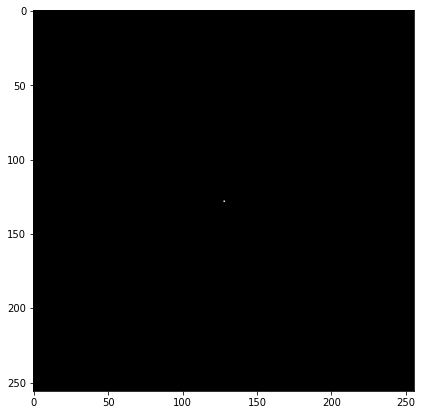

In [ ]:
#Genero un impulso de 256x256 pixeles

N = 256
plt.figure(figsize=(7, 7)) 
impulse = np.zeros((N, N)) # imagen de 256x256
impulse[N//2, N//2] = 1 # impulso
plt.imshow(impulse, cmap='gray', vmin=0, vmax=1) ;

Se convoluciona el filtro dado con la delta y luego se hace zoom para poder verlo mejor: 


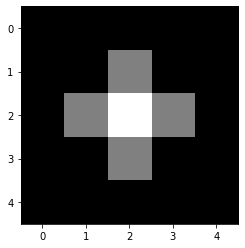

In [ ]:
h = np.array([[0,1/6, 0], [1/6, 1/3, 1/6], [0, 1/6, 0]])

filtered = convolve(impulse, h)

#Show limits 
low = N//2 - 2
high = N//2 + 2+1

zoomed = filtered[low:high, low:high]

plt.imshow(zoomed, cmap='gray', vmin=0, vmax=1/3);

Espectro:

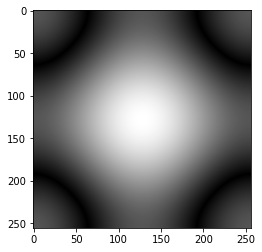

In [ ]:
spectrum = np.fft.fft2(filtered)
module = np.abs(np.fft.fftshift(spectrum))
maxValue = np.max(module)
plt.imshow(module, cmap='gray', vmin=0, vmax=maxValue);

Gráfico 3d del espectro:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


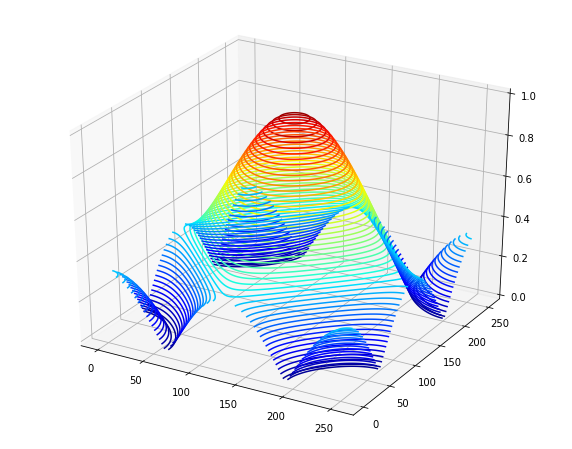

In [ ]:
plt.figure(figsize =(10, 8)) 
ax = plt.axes(projection='3d')
m,n = module.shape
X = np.array(range(m))
Y = np.array(range(n))
Z = module
ax.contour3D(X, Y, module, 50, cmap='jet');


Espectro en escala logaritmica:

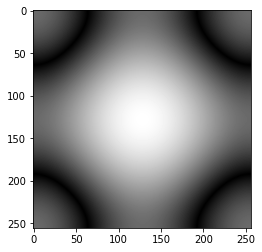

In [ ]:
spectrum = np.fft.fft2(filtered)
module = np.log10(1+np.abs(np.fft.fftshift(spectrum))) # 1+ para que no haga np.log(0)
max_val = np.max(module)
plt.imshow(module,cmap='gray', vmin=0, vmax=max_val)

# Respuesta con filtro circular promediador (disk):

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: ComplexWarning: Casting complex values to real discards the imaginary part


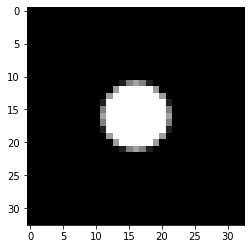

In [ ]:
#Se crea un filtro promedidaro circular de radio 5 y se grafica la respuesta impulsiva: se puede ver la forma del circulo circunscrito y como los bordes tienen menor intensidad según la formula explicada anteriormente.
#El resultado debería ser una imagen difuminada, ya que se están promediando los valores de los pixeles. 
hDisk = getFilterKernel('disk', radius=5)
filtered2 = convolve(impulse, hDisk)

low = N//2 - 16
high = N//2 + 16+1

zoomDisk = filtered2[low:high, low:high]
plt.imshow(zoomDisk,cmap='gray', vmin=0, vmax=0.01);

Espectro:

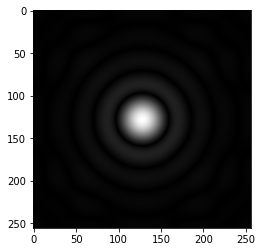

In [ ]:
spectrum = np.fft.fft2(filtered2)
module = np.abs(np.fft.fftshift(spectrum))
maxValue = np.max(module)
plt.imshow(module,cmap='gray', vmin=0, vmax=maxValue);

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


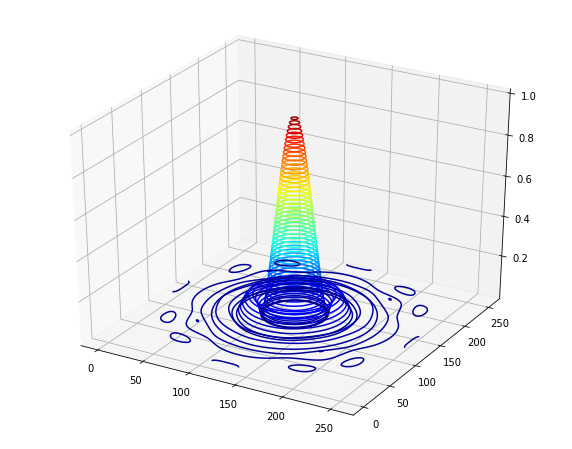

In [ ]:
plt.figure(figsize =(10, 8)) 
ax = plt.axes(projection='3d')
m,n = module.shape
X = np.array(range(m))
Y = np.array(range(n))
Z = module
ax.contour3D(X, Y, module, 50, cmap='jet')

#Respuesta con filtro unsharp:

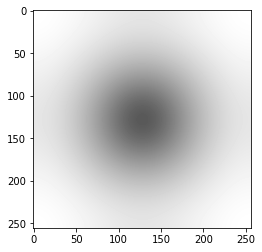

In [ ]:
#Se crea un filtro unsharp con alpha=0.2, el resultado debería ser una imagen cuyas altas frecuencias se ven resaltadas. 
unsharp = getFilterKernel(type='unsharp', alpha=0.2)
filteredUnsharp = convolve(impulse, unsharp)

spectrum = np.fft.fft2(filteredUnsharp)
module = np.log10(1+np.abs(np.fft.fftshift(spectrum))) 
max_val = np.max(module)
plt.imshow(module,cmap='gray', vmin=0, vmax=max_val)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


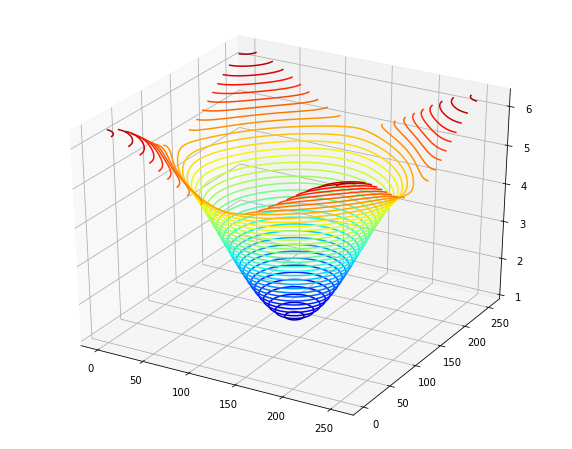

In [ ]:
plt.figure(figsize =(10, 8)) 
ax = plt.axes(projection='3d')
mun,nun = moduleUnsharp.shape
Xun = np.array(range(mun))
Yun = np.array(range(nun))
Zun = moduleUnsharp
ax.contour3D(Xun, Yun, moduleUnsharp, 50, cmap='jet');

En escala logaritmica:

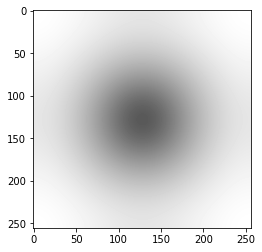

In [ ]:
spectrum = np.fft.fft2(filteredUnsharp)
module = np.log10(1+np.abs(np.fft.fftshift(spectrum))) # 1+ para que no haga np.log(0)
max_val = np.max(module)
plt.imshow(module,cmap='gray', vmin=0, vmax=max_val)

#Extra, testeo de filtros en imagenes:

Filtro disk:

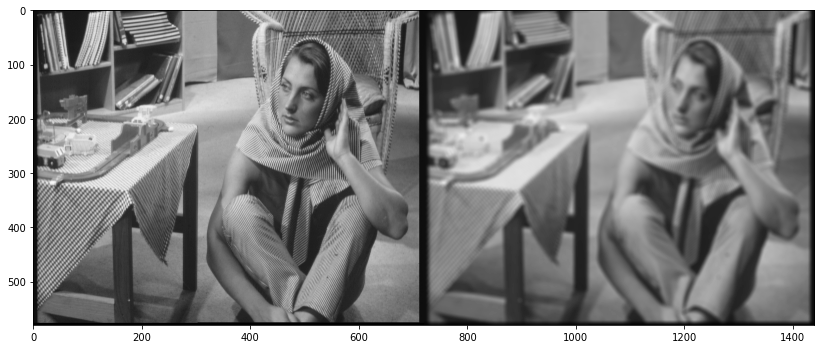

In [ ]:
imagenOG = plt.imread('/content/drive/Shareddrives/Imagenes/TP2 Grupo 2/barbara.gif')

imagenOG = cv.cvtColor(imagenOG, cv.COLOR_BGRA2GRAY)
filtered = convolve(imagenOG, h2)

arr = np.hstack((imagenOG, filtered))


plt.figure(figsize =(14, 10)) 
plt.imshow(arr, cmap='gray');



Se nota como el filtro circular promediador funciona como un pasabajos, se le resta nitidez a la imagen original.



> 



Filtro unsharp:

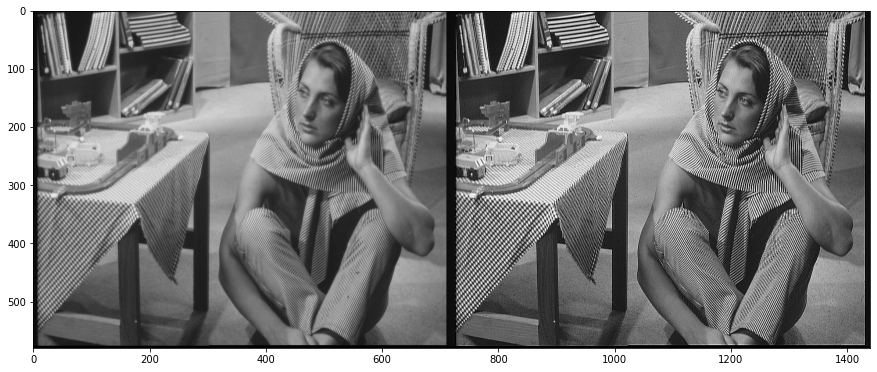

In [ ]:
hSharp = getFilterKernel('unsharp', alpha=0.2)

filteredSharp = convolve(imagenOG, hSharp)

arr2 = np.hstack((imagenOG, filteredSharp))

plt.figure(figsize =(15, 15)) 
plt.imshow(arr2, cmap='gray');


En éste caso se resaltan las altas frecuencias, los detalles donde hay más contraste se ven amplificados y las partes más complejas de la imagen tienen bordes más predominantes.